In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

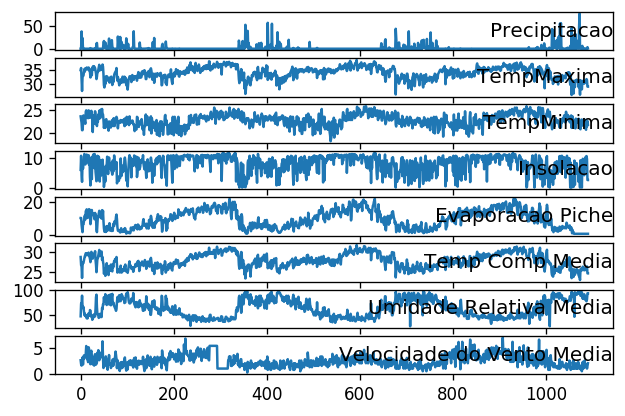

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

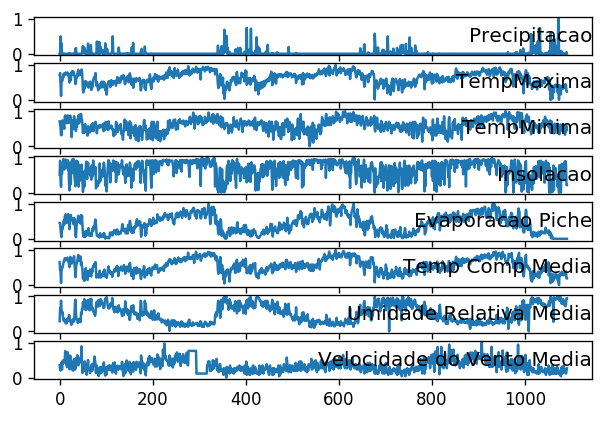

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2591 - mean_squared_error: 0.1118 - val_loss: 0.1979 - val_mean_squared_error: 0.0575
Epoch 2/1000
 - 0s - loss: 0.1506 - mean_squared_error: 0.0351 - val_loss: 0.1733 - val_mean_squared_error: 0.0468
Epoch 3/1000
 - 1s - loss: 0.1408 - mean_squared_error: 0.0316 - val_loss: 0.1855 - val_mean_squared_error: 0.0562
Epoch 4/1000
 - 1s - loss: 0.1367 - mean_squared_error: 0.0296 - val_loss: 0.1469 - val_mean_squared_error: 0.0429
Epoch 5/1000
 - 0s - loss: 0.1312 - mean_squared_error: 0.0275 - val_loss: 0.1504 - val_mean_squared_error: 0.0392
Epoch 6/1000
 - 0s - loss: 0.1271 - mean_squared_error: 0.0256 - val_loss: 0.1649 - val_mean_squared_error: 0.0478
Epoch 7/1000
 - 1s - loss: 0.1200 - mean_squared_error: 0.0234 - val_loss: 0.1500 - val_mean_squared_error: 0.0396
Epoch 8/1000
 - 1s - loss: 0.1141 - mean_squared_error: 0.0213 - val_loss: 0.1598 - val_mean_squared_error: 0.0459
Epoch 9/1000
 - 1s - loss: 0.1116 -

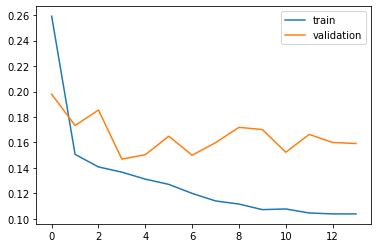


predict: [[35.0905223  33.73565899]]
real:      [[18.09923077 31.95789474]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3135 - mean_squared_error: 0.1403 - val_loss: 0.2009 - val_mean_squared_error: 0.0500
Epoch 2/1000
 - 0s - loss: 0.1604 - mean_squared_error: 0.0413 - val_loss: 0.0825 - val_mean_squared_error: 0.0073
Epoch 3/1000
 - 0s - loss: 0.1421 - mean_squared_error: 0.0336 - val_loss: 0.1355 - val_mean_squared_error: 0.0184
Epoch 4/1000
 - 0s - loss: 0.1379 - mean_squared_error: 0.0306 - val_loss: 0.1358 - val_mean_squared_error: 0.0184
Epoch 5/1000
 - 0s - loss: 0.1338 - mean_squared_error: 0.0294 - val_loss: 0.1230 - val_mean_squared_error: 0.0155
Epoch 6/1000
 - 0s - loss: 0.1307 - mean_squared_error: 0.0277 - val_loss: 0.1330 - val_mean_squared_error: 0.0178
Epoch 7/1000
 - 0s - loss: 0.1227 - mean_squared_error: 0.0250 - val_loss: 0.1195 - val_mean_squared_error: 0.0147
Epoch 8/1000
 - 0s - loss: 0.1133 - mean_squared_error: 0.0214 - val_los

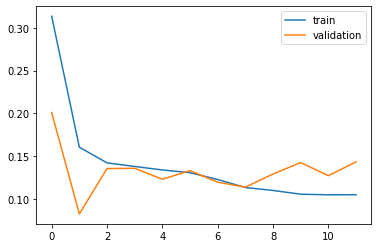


predict: [[34.67597755 32.34511857]]
real:      [[18.09923077 33.32631579]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2860 - mean_squared_error: 0.1211 - val_loss: 0.1068 - val_mean_squared_error: 0.0226
Epoch 2/1000
 - 0s - loss: 0.1563 - mean_squared_error: 0.0404 - val_loss: 0.0866 - val_mean_squared_error: 0.0076
Epoch 3/1000
 - 0s - loss: 0.1440 - mean_squared_error: 0.0332 - val_loss: 0.0588 - val_mean_squared_error: 0.0046
Epoch 4/1000
 - 1s - loss: 0.1386 - mean_squared_error: 0.0305 - val_loss: 0.0738 - val_mean_squared_error: 0.0092
Epoch 5/1000
 - 1s - loss: 0.1317 - mean_squared_error: 0.0282 - val_loss: 0.0724 - val_mean_squared_error: 0.0057
Epoch 6/1000
 - 0s - loss: 0.1174 - mean_squared_error: 0.0228 - val_loss: 0.0709 - val_mean_squared_error: 0.0051
Epoch 7/1000
 - 1s - loss: 0.1116 - mean_squared_error: 0.0203 - val_loss: 0.0571 - val_mean_squared_error: 0.0058
Epoch 8/1000
 - 1s - loss: 0.1074 - mean_squared_error: 0.0194 - val_los

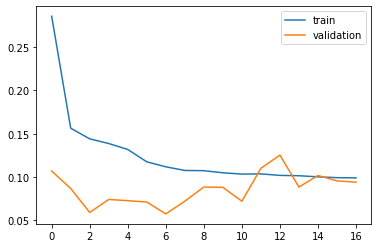


predict: [[36.00087627 33.19874429]]
real:      [[32.11153846 31.27368421]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4011 - mean_squared_error: 0.2049 - val_loss: 0.1620 - val_mean_squared_error: 0.0490
Epoch 2/1000
 - 1s - loss: 0.1437 - mean_squared_error: 0.0325 - val_loss: 0.2372 - val_mean_squared_error: 0.0641
Epoch 3/1000
 - 0s - loss: 0.1306 - mean_squared_error: 0.0268 - val_loss: 0.2222 - val_mean_squared_error: 0.0518
Epoch 4/1000
 - 0s - loss: 0.1238 - mean_squared_error: 0.0245 - val_loss: 0.2204 - val_mean_squared_error: 0.0522
Epoch 5/1000
 - 0s - loss: 0.1193 - mean_squared_error: 0.0229 - val_loss: 0.1898 - val_mean_squared_error: 0.0401
Epoch 6/1000
 - 0s - loss: 0.1153 - mean_squared_error: 0.0214 - val_loss: 0.2328 - val_mean_squared_error: 0.0631
Epoch 7/1000
 - 0s - loss: 0.1116 - mean_squared_error: 0.0203 - val_loss: 0.1843 - val_mean_squared_error: 0.0388
Epoch 8/1000
 - 0s - loss: 0.1093 - mean_squared_error: 0.0197 - val_los

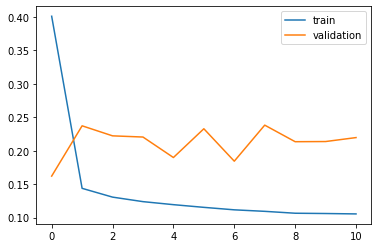


predict: [[27.80483363 33.95152967]]
real:      [[34.44692308 33.66842105]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3694 - mean_squared_error: 0.2059 - val_loss: 0.2974 - val_mean_squared_error: 0.0888
Epoch 2/1000
 - 1s - loss: 0.1540 - mean_squared_error: 0.0389 - val_loss: 0.1755 - val_mean_squared_error: 0.0313
Epoch 3/1000
 - 1s - loss: 0.1411 - mean_squared_error: 0.0324 - val_loss: 0.1806 - val_mean_squared_error: 0.0328
Epoch 4/1000
 - 0s - loss: 0.1345 - mean_squared_error: 0.0297 - val_loss: 0.1752 - val_mean_squared_error: 0.0309
Epoch 5/1000
 - 0s - loss: 0.1282 - mean_squared_error: 0.0271 - val_loss: 0.1967 - val_mean_squared_error: 0.0391
Epoch 6/1000
 - 0s - loss: 0.1229 - mean_squared_error: 0.0251 - val_loss: 0.2159 - val_mean_squared_error: 0.0471
Epoch 7/1000
 - 0s - loss: 0.1180 - mean_squared_error: 0.0232 - val_loss: 0.2497 - val_mean_squared_error: 0.0631
Epoch 8/1000
 - 1s - loss: 0.1139 - mean_squared_error: 0.0221 - val_los

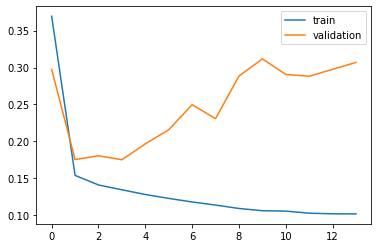


predict: [[39.16688613 32.64963715]]
real:      [[30.36       30.07631579]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5713 - mean_squared_error: 0.3854 - val_loss: 0.1355 - val_mean_squared_error: 0.0190
Epoch 2/1000
 - 0s - loss: 0.2108 - mean_squared_error: 0.0688 - val_loss: 0.2669 - val_mean_squared_error: 0.0863
Epoch 3/1000
 - 0s - loss: 0.1473 - mean_squared_error: 0.0341 - val_loss: 0.1460 - val_mean_squared_error: 0.0213
Epoch 4/1000
 - 0s - loss: 0.1378 - mean_squared_error: 0.0297 - val_loss: 0.2148 - val_mean_squared_error: 0.0465
Epoch 5/1000
 - 1s - loss: 0.1337 - mean_squared_error: 0.0284 - val_loss: 0.1703 - val_mean_squared_error: 0.0300
Epoch 6/1000
 - 1s - loss: 0.1300 - mean_squared_error: 0.0270 - val_loss: 0.1723 - val_mean_squared_error: 0.0299
Epoch 7/1000
 - 0s - loss: 0.1250 - mean_squared_error: 0.0247 - val_loss: 0.1668 - val_mean_squared_error: 0.0281
Epoch 8/1000
 - 0s - loss: 0.1170 - mean_squared_error: 0.0219 - val_los

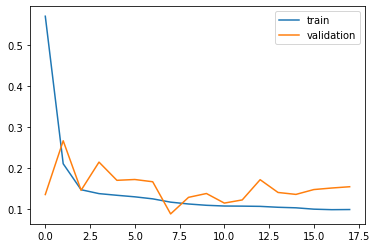


predict: [[34.79927897 33.55388449]]
real:      [[28.60846154 30.41842105]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3156 - mean_squared_error: 0.1433 - val_loss: 0.2046 - val_mean_squared_error: 0.0473
Epoch 2/1000
 - 1s - loss: 0.1462 - mean_squared_error: 0.0362 - val_loss: 0.1104 - val_mean_squared_error: 0.0188
Epoch 3/1000
 - 1s - loss: 0.1339 - mean_squared_error: 0.0290 - val_loss: 0.1274 - val_mean_squared_error: 0.0214
Epoch 4/1000
 - 1s - loss: 0.1284 - mean_squared_error: 0.0265 - val_loss: 0.1328 - val_mean_squared_error: 0.0210
Epoch 5/1000
 - 0s - loss: 0.1224 - mean_squared_error: 0.0246 - val_loss: 0.1586 - val_mean_squared_error: 0.0288
Epoch 6/1000
 - 1s - loss: 0.1171 - mean_squared_error: 0.0226 - val_loss: 0.1057 - val_mean_squared_error: 0.0164
Epoch 7/1000
 - 1s - loss: 0.1131 - mean_squared_error: 0.0206 - val_loss: 0.1226 - val_mean_squared_error: 0.0194
Epoch 8/1000
 - 1s - loss: 0.1107 - mean_squared_error: 0.0202 - val_los

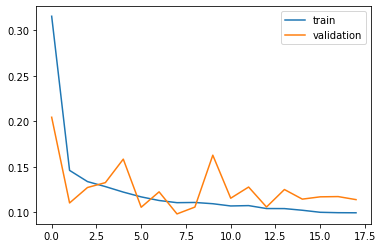


predict: [[34.44621754 33.17594867]]
real:      [[28.02461538 31.61578947]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4570 - mean_squared_error: 0.2660 - val_loss: 0.0972 - val_mean_squared_error: 0.0107
Epoch 2/1000
 - 1s - loss: 0.1778 - mean_squared_error: 0.0521 - val_loss: 0.2398 - val_mean_squared_error: 0.0613
Epoch 3/1000
 - 1s - loss: 0.1454 - mean_squared_error: 0.0334 - val_loss: 0.1590 - val_mean_squared_error: 0.0406
Epoch 4/1000
 - 1s - loss: 0.1350 - mean_squared_error: 0.0296 - val_loss: 0.1283 - val_mean_squared_error: 0.0299
Epoch 5/1000
 - 1s - loss: 0.1290 - mean_squared_error: 0.0266 - val_loss: 0.1466 - val_mean_squared_error: 0.0319
Epoch 6/1000
 - 1s - loss: 0.1252 - mean_squared_error: 0.0250 - val_loss: 0.1482 - val_mean_squared_error: 0.0322
Epoch 7/1000
 - 1s - loss: 0.1226 - mean_squared_error: 0.0239 - val_loss: 0.1289 - val_mean_squared_error: 0.0302
Epoch 8/1000
 - 1s - loss: 0.1183 - mean_squared_error: 0.0224 - val_los

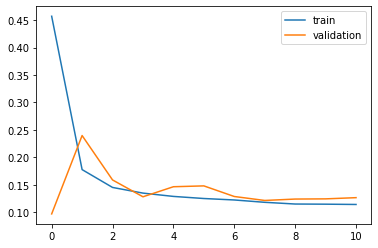


predict: [[34.42207299 32.32476376]]
real:      [[26.27307692 32.64210526]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3536 - mean_squared_error: 0.1962 - val_loss: 0.0607 - val_mean_squared_error: 0.0038
Epoch 2/1000
 - 0s - loss: 0.1477 - mean_squared_error: 0.0344 - val_loss: 0.1197 - val_mean_squared_error: 0.0186
Epoch 3/1000
 - 1s - loss: 0.1327 - mean_squared_error: 0.0282 - val_loss: 0.0838 - val_mean_squared_error: 0.0124
Epoch 4/1000
 - 1s - loss: 0.1256 - mean_squared_error: 0.0255 - val_loss: 0.0777 - val_mean_squared_error: 0.0119
Epoch 5/1000
 - 1s - loss: 0.1178 - mean_squared_error: 0.0224 - val_loss: 0.0852 - val_mean_squared_error: 0.0120
Epoch 6/1000
 - 0s - loss: 0.1149 - mean_squared_error: 0.0214 - val_loss: 0.0924 - val_mean_squared_error: 0.0134
Epoch 7/1000
 - 1s - loss: 0.1181 - mean_squared_error: 0.0231 - val_loss: 0.0811 - val_mean_squared_error: 0.0105
Epoch 8/1000
 - 0s - loss: 0.1129 - mean_squared_error: 0.0206 - val_los

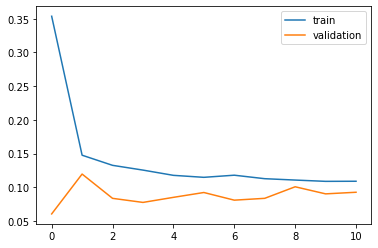


predict: [[31.668839   34.36788152]]
real:      [[24.52153846 34.01052632]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5736 - mean_squared_error: 0.3704 - val_loss: 0.2956 - val_mean_squared_error: 0.0967
Epoch 2/1000
 - 1s - loss: 0.3251 - mean_squared_error: 0.1621 - val_loss: 0.1417 - val_mean_squared_error: 0.0281
Epoch 3/1000
 - 1s - loss: 0.1568 - mean_squared_error: 0.0393 - val_loss: 0.1035 - val_mean_squared_error: 0.0196
Epoch 4/1000
 - 0s - loss: 0.1397 - mean_squared_error: 0.0304 - val_loss: 0.1687 - val_mean_squared_error: 0.0351
Epoch 5/1000
 - 0s - loss: 0.1359 - mean_squared_error: 0.0288 - val_loss: 0.1684 - val_mean_squared_error: 0.0309
Epoch 6/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0258 - val_loss: 0.1147 - val_mean_squared_error: 0.0157
Epoch 7/1000
 - 0s - loss: 0.1192 - mean_squared_error: 0.0231 - val_loss: 0.1424 - val_mean_squared_error: 0.0219
Epoch 8/1000
 - 0s - loss: 0.1200 - mean_squared_error: 0.0235 - val_los

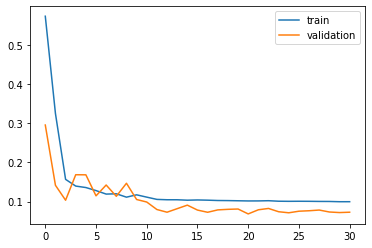


predict: [[36.10972805 33.11615424]]
real:      [[30.94384615 33.49736842]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3323 - mean_squared_error: 0.1574 - val_loss: 0.1877 - val_mean_squared_error: 0.0533
Epoch 2/1000
 - 0s - loss: 0.1594 - mean_squared_error: 0.0406 - val_loss: 0.1138 - val_mean_squared_error: 0.0129
Epoch 3/1000
 - 0s - loss: 0.1394 - mean_squared_error: 0.0309 - val_loss: 0.0857 - val_mean_squared_error: 0.0124
Epoch 4/1000
 - 0s - loss: 0.1340 - mean_squared_error: 0.0283 - val_loss: 0.0682 - val_mean_squared_error: 0.0086
Epoch 5/1000
 - 0s - loss: 0.1243 - mean_squared_error: 0.0250 - val_loss: 0.0849 - val_mean_squared_error: 0.0113
Epoch 6/1000
 - 0s - loss: 0.1152 - mean_squared_error: 0.0217 - val_loss: 0.0748 - val_mean_squared_error: 0.0105
Epoch 7/1000
 - 0s - loss: 0.1124 - mean_squared_error: 0.0208 - val_loss: 0.0840 - val_mean_squared_error: 0.0122
Epoch 8/1000
 - 0s - loss: 0.1092 - mean_squared_error: 0.0198 - val_los

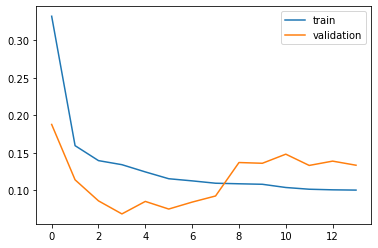


predict: [[34.2330719  32.85564231]]
real:      [[30.94384615 32.64210526]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6036 - mean_squared_error: 0.4013 - val_loss: 0.2222 - val_mean_squared_error: 0.0779
Epoch 2/1000
 - 0s - loss: 0.3224 - mean_squared_error: 0.1504 - val_loss: 0.1296 - val_mean_squared_error: 0.0189
Epoch 3/1000
 - 0s - loss: 0.1555 - mean_squared_error: 0.0377 - val_loss: 0.1857 - val_mean_squared_error: 0.0354
Epoch 4/1000
 - 0s - loss: 0.1361 - mean_squared_error: 0.0288 - val_loss: 0.2064 - val_mean_squared_error: 0.0426
Epoch 5/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0274 - val_loss: 0.1859 - val_mean_squared_error: 0.0347
Epoch 6/1000
 - 0s - loss: 0.1288 - mean_squared_error: 0.0266 - val_loss: 0.1537 - val_mean_squared_error: 0.0238
Epoch 7/1000
 - 0s - loss: 0.1260 - mean_squared_error: 0.0255 - val_loss: 0.1561 - val_mean_squared_error: 0.0246
Epoch 8/1000
 - 0s - loss: 0.1255 - mean_squared_error: 0.0255 - val_los

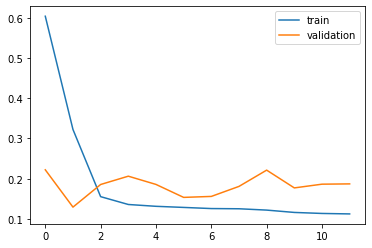


predict: [[40.52208881 29.8809285 ]]
real:      [[30.36       33.49736842]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3502 - mean_squared_error: 0.1721 - val_loss: 0.3882 - val_mean_squared_error: 0.2047
Epoch 2/1000
 - 1s - loss: 0.1513 - mean_squared_error: 0.0372 - val_loss: 0.2424 - val_mean_squared_error: 0.0857
Epoch 3/1000
 - 0s - loss: 0.1336 - mean_squared_error: 0.0283 - val_loss: 0.2089 - val_mean_squared_error: 0.0804
Epoch 4/1000
 - 0s - loss: 0.1300 - mean_squared_error: 0.0269 - val_loss: 0.1996 - val_mean_squared_error: 0.0698
Epoch 5/1000
 - 0s - loss: 0.1221 - mean_squared_error: 0.0243 - val_loss: 0.2162 - val_mean_squared_error: 0.0796
Epoch 6/1000
 - 1s - loss: 0.1184 - mean_squared_error: 0.0232 - val_loss: 0.2118 - val_mean_squared_error: 0.0752
Epoch 7/1000
 - 1s - loss: 0.1147 - mean_squared_error: 0.0215 - val_loss: 0.1989 - val_mean_squared_error: 0.0737
Epoch 8/1000
 - 0s - loss: 0.1109 - mean_squared_error: 0.0207 - val_los

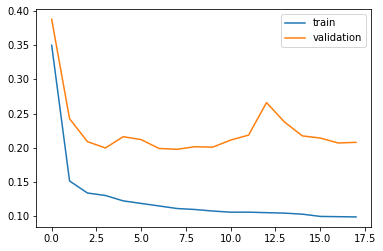


predict: [[29.32843289 31.91374527]]
real:      [[28.60846154 31.61578947]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4506 - mean_squared_error: 0.2588 - val_loss: 0.0539 - val_mean_squared_error: 0.0033
Epoch 2/1000
 - 0s - loss: 0.2553 - mean_squared_error: 0.0950 - val_loss: 0.0335 - val_mean_squared_error: 0.0018
Epoch 3/1000
 - 0s - loss: 0.1853 - mean_squared_error: 0.0530 - val_loss: 0.1389 - val_mean_squared_error: 0.0350
Epoch 4/1000
 - 1s - loss: 0.1385 - mean_squared_error: 0.0309 - val_loss: 0.2023 - val_mean_squared_error: 0.0777
Epoch 5/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0284 - val_loss: 0.1679 - val_mean_squared_error: 0.0481
Epoch 6/1000
 - 0s - loss: 0.1226 - mean_squared_error: 0.0241 - val_loss: 0.2068 - val_mean_squared_error: 0.0703
Epoch 7/1000
 - 0s - loss: 0.1189 - mean_squared_error: 0.0237 - val_loss: 0.1612 - val_mean_squared_error: 0.0372
Epoch 8/1000
 - 1s - loss: 0.1122 - mean_squared_error: 0.0206 - val_los

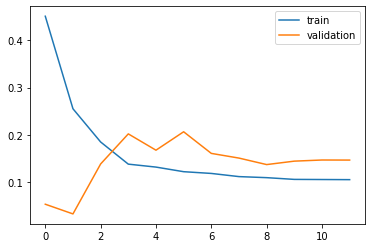


predict: [[23.39808262 32.48067575]]
real:      [[12.26076923 33.83947368]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3065 - mean_squared_error: 0.1354 - val_loss: 0.2412 - val_mean_squared_error: 0.0582
Epoch 2/1000
 - 0s - loss: 0.1467 - mean_squared_error: 0.0360 - val_loss: 0.1028 - val_mean_squared_error: 0.0162
Epoch 3/1000
 - 0s - loss: 0.1342 - mean_squared_error: 0.0295 - val_loss: 0.1626 - val_mean_squared_error: 0.0271
Epoch 4/1000
 - 0s - loss: 0.1269 - mean_squared_error: 0.0261 - val_loss: 0.1700 - val_mean_squared_error: 0.0295
Epoch 5/1000
 - 0s - loss: 0.1181 - mean_squared_error: 0.0232 - val_loss: 0.1214 - val_mean_squared_error: 0.0160
Epoch 6/1000
 - 1s - loss: 0.1144 - mean_squared_error: 0.0212 - val_loss: 0.1039 - val_mean_squared_error: 0.0111
Epoch 7/1000
 - 0s - loss: 0.1131 - mean_squared_error: 0.0208 - val_loss: 0.1466 - val_mean_squared_error: 0.0221
Epoch 8/1000
 - 0s - loss: 0.1076 - mean_squared_error: 0.0195 - val_los

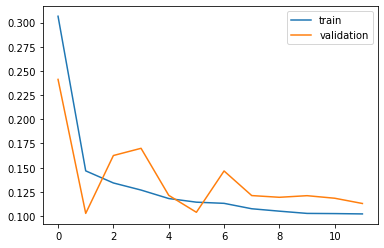


predict: [[34.49684781 31.94702824]]
real:      [[21.60230769 33.83947368]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2634 - mean_squared_error: 0.1171 - val_loss: 0.2033 - val_mean_squared_error: 0.0416
Epoch 2/1000
 - 0s - loss: 0.1452 - mean_squared_error: 0.0334 - val_loss: 0.1908 - val_mean_squared_error: 0.0437
Epoch 3/1000
 - 1s - loss: 0.1290 - mean_squared_error: 0.0267 - val_loss: 0.1809 - val_mean_squared_error: 0.0339
Epoch 4/1000
 - 0s - loss: 0.1209 - mean_squared_error: 0.0239 - val_loss: 0.2031 - val_mean_squared_error: 0.0449
Epoch 5/1000
 - 0s - loss: 0.1161 - mean_squared_error: 0.0225 - val_loss: 0.1756 - val_mean_squared_error: 0.0338
Epoch 6/1000
 - 0s - loss: 0.1201 - mean_squared_error: 0.0238 - val_loss: 0.2226 - val_mean_squared_error: 0.0520
Epoch 7/1000
 - 1s - loss: 0.1138 - mean_squared_error: 0.0218 - val_loss: 0.2129 - val_mean_squared_error: 0.0499
Epoch 8/1000
 - 0s - loss: 0.1096 - mean_squared_error: 0.0201 - val_los

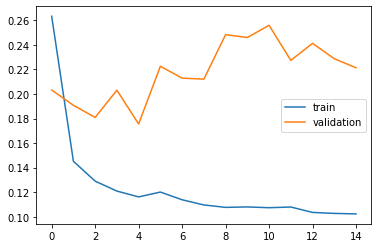


predict: [[26.17214508 31.73512136]]
real:      [[28.60846154 31.78684211]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3848 - mean_squared_error: 0.2000 - val_loss: 0.4314 - val_mean_squared_error: 0.2009
Epoch 2/1000
 - 0s - loss: 0.1705 - mean_squared_error: 0.0490 - val_loss: 0.2693 - val_mean_squared_error: 0.1221
Epoch 3/1000
 - 0s - loss: 0.1527 - mean_squared_error: 0.0366 - val_loss: 0.3825 - val_mean_squared_error: 0.1766
Epoch 4/1000
 - 0s - loss: 0.1434 - mean_squared_error: 0.0330 - val_loss: 0.3690 - val_mean_squared_error: 0.1679
Epoch 5/1000
 - 1s - loss: 0.1371 - mean_squared_error: 0.0298 - val_loss: 0.3705 - val_mean_squared_error: 0.1684
Epoch 6/1000
 - 0s - loss: 0.1287 - mean_squared_error: 0.0270 - val_loss: 0.3305 - val_mean_squared_error: 0.1392
Epoch 7/1000
 - 0s - loss: 0.1258 - mean_squared_error: 0.0252 - val_loss: 0.3151 - val_mean_squared_error: 0.1304
Epoch 8/1000
 - 0s - loss: 0.1221 - mean_squared_error: 0.0241 - val_los

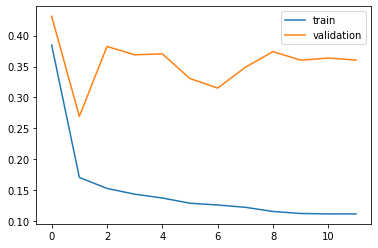


predict: [[34.35529434 30.67555596]]
real:      [[32.11153846 30.24736842]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3035 - mean_squared_error: 0.1348 - val_loss: 0.2467 - val_mean_squared_error: 0.0714
Epoch 2/1000
 - 1s - loss: 0.1506 - mean_squared_error: 0.0359 - val_loss: 0.2399 - val_mean_squared_error: 0.0591
Epoch 3/1000
 - 1s - loss: 0.1375 - mean_squared_error: 0.0302 - val_loss: 0.2505 - val_mean_squared_error: 0.0647
Epoch 4/1000
 - 0s - loss: 0.1331 - mean_squared_error: 0.0281 - val_loss: 0.2333 - val_mean_squared_error: 0.0554
Epoch 5/1000
 - 0s - loss: 0.1251 - mean_squared_error: 0.0250 - val_loss: 0.2611 - val_mean_squared_error: 0.0697
Epoch 6/1000
 - 0s - loss: 0.1176 - mean_squared_error: 0.0227 - val_loss: 0.2938 - val_mean_squared_error: 0.0870
Epoch 7/1000
 - 0s - loss: 0.1181 - mean_squared_error: 0.0235 - val_loss: 0.2531 - val_mean_squared_error: 0.0648
Epoch 8/1000
 - 0s - loss: 0.1131 - mean_squared_error: 0.0211 - val_los

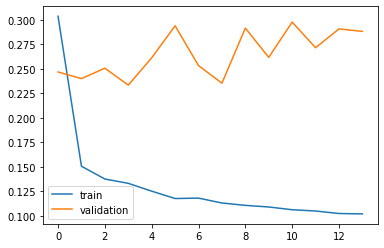


predict: [[35.51559438 33.23486285]]
real:      [[ 0.58384615 30.76052632]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5626 - mean_squared_error: 0.3735 - val_loss: 0.1529 - val_mean_squared_error: 0.0319
Epoch 2/1000
 - 0s - loss: 0.2050 - mean_squared_error: 0.0650 - val_loss: 0.1951 - val_mean_squared_error: 0.0382
Epoch 3/1000
 - 0s - loss: 0.1357 - mean_squared_error: 0.0291 - val_loss: 0.1262 - val_mean_squared_error: 0.0170
Epoch 4/1000
 - 0s - loss: 0.1357 - mean_squared_error: 0.0286 - val_loss: 0.1642 - val_mean_squared_error: 0.0280
Epoch 5/1000
 - 0s - loss: 0.1268 - mean_squared_error: 0.0252 - val_loss: 0.1326 - val_mean_squared_error: 0.0215
Epoch 6/1000
 - 0s - loss: 0.1241 - mean_squared_error: 0.0244 - val_loss: 0.1588 - val_mean_squared_error: 0.0259
Epoch 7/1000
 - 0s - loss: 0.1192 - mean_squared_error: 0.0232 - val_loss: 0.1037 - val_mean_squared_error: 0.0139
Epoch 8/1000
 - 0s - loss: 0.1143 - mean_squared_error: 0.0216 - val_los

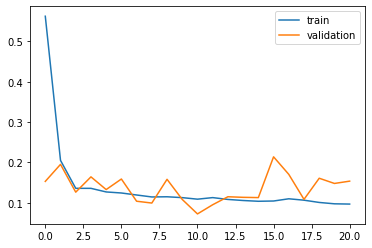


predict: [[31.56486181 31.74823045]]
real:      [[19.85076923 30.58947368]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4198 - mean_squared_error: 0.2277 - val_loss: 0.3243 - val_mean_squared_error: 0.1340
Epoch 2/1000
 - 0s - loss: 0.1716 - mean_squared_error: 0.0471 - val_loss: 0.2178 - val_mean_squared_error: 0.0551
Epoch 3/1000
 - 0s - loss: 0.1499 - mean_squared_error: 0.0363 - val_loss: 0.2295 - val_mean_squared_error: 0.0689
Epoch 4/1000
 - 0s - loss: 0.1416 - mean_squared_error: 0.0315 - val_loss: 0.2234 - val_mean_squared_error: 0.0686
Epoch 5/1000
 - 1s - loss: 0.1337 - mean_squared_error: 0.0292 - val_loss: 0.2046 - val_mean_squared_error: 0.0534
Epoch 6/1000
 - 1s - loss: 0.1222 - mean_squared_error: 0.0246 - val_loss: 0.2104 - val_mean_squared_error: 0.0479
Epoch 7/1000
 - 1s - loss: 0.1256 - mean_squared_error: 0.0249 - val_loss: 0.1953 - val_mean_squared_error: 0.0484
Epoch 8/1000
 - 1s - loss: 0.1170 - mean_squared_error: 0.0222 - val_los

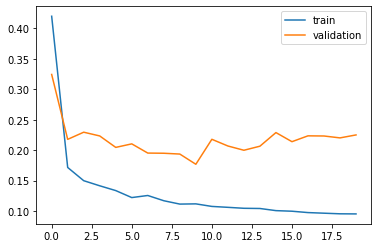


predict: [[31.68360078 33.37955641]]
real:      [[30.94384615 31.61578947]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3273 - mean_squared_error: 0.1768 - val_loss: 0.2043 - val_mean_squared_error: 0.0467
Epoch 2/1000
 - 0s - loss: 0.1601 - mean_squared_error: 0.0391 - val_loss: 0.1149 - val_mean_squared_error: 0.0138
Epoch 3/1000
 - 1s - loss: 0.1347 - mean_squared_error: 0.0282 - val_loss: 0.0991 - val_mean_squared_error: 0.0102
Epoch 4/1000
 - 1s - loss: 0.1301 - mean_squared_error: 0.0263 - val_loss: 0.1242 - val_mean_squared_error: 0.0155
Epoch 5/1000
 - 0s - loss: 0.1227 - mean_squared_error: 0.0240 - val_loss: 0.1158 - val_mean_squared_error: 0.0148
Epoch 6/1000
 - 1s - loss: 0.1194 - mean_squared_error: 0.0232 - val_loss: 0.1050 - val_mean_squared_error: 0.0113
Epoch 7/1000
 - 0s - loss: 0.1172 - mean_squared_error: 0.0226 - val_loss: 0.1383 - val_mean_squared_error: 0.0193
Epoch 8/1000
 - 0s - loss: 0.1213 - mean_squared_error: 0.0241 - val_los

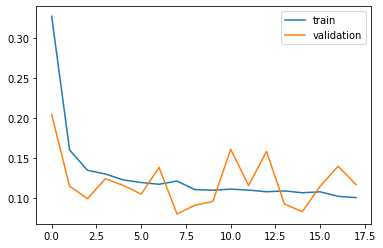


predict: [[32.97940797 32.70163028]]
real:      [[16.93153846 34.18157895]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5931 - mean_squared_error: 0.3880 - val_loss: 0.2584 - val_mean_squared_error: 0.0704
Epoch 2/1000
 - 0s - loss: 0.2422 - mean_squared_error: 0.0887 - val_loss: 0.2308 - val_mean_squared_error: 0.0567
Epoch 3/1000
 - 0s - loss: 0.1510 - mean_squared_error: 0.0350 - val_loss: 0.1076 - val_mean_squared_error: 0.0189
Epoch 4/1000
 - 0s - loss: 0.1417 - mean_squared_error: 0.0325 - val_loss: 0.1694 - val_mean_squared_error: 0.0359
Epoch 5/1000
 - 0s - loss: 0.1367 - mean_squared_error: 0.0295 - val_loss: 0.1437 - val_mean_squared_error: 0.0267
Epoch 6/1000
 - 0s - loss: 0.1325 - mean_squared_error: 0.0284 - val_loss: 0.1573 - val_mean_squared_error: 0.0302
Epoch 7/1000
 - 0s - loss: 0.1250 - mean_squared_error: 0.0250 - val_loss: 0.1415 - val_mean_squared_error: 0.0212
Epoch 8/1000
 - 0s - loss: 0.1214 - mean_squared_error: 0.0240 - val_los

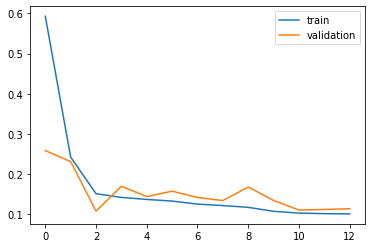


predict: [[42.30170081 32.25608711]]
real:      [[31.52769231 32.64210526]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4855 - mean_squared_error: 0.3270 - val_loss: 0.0524 - val_mean_squared_error: 0.0029
Epoch 2/1000
 - 0s - loss: 0.1686 - mean_squared_error: 0.0442 - val_loss: 0.0119 - val_mean_squared_error: 1.4957e-04
Epoch 3/1000
 - 0s - loss: 0.1476 - mean_squared_error: 0.0334 - val_loss: 0.0989 - val_mean_squared_error: 0.0134
Epoch 4/1000
 - 0s - loss: 0.1377 - mean_squared_error: 0.0300 - val_loss: 0.0537 - val_mean_squared_error: 0.0054
Epoch 5/1000
 - 0s - loss: 0.1328 - mean_squared_error: 0.0276 - val_loss: 0.0996 - val_mean_squared_error: 0.0146
Epoch 6/1000
 - 0s - loss: 0.1279 - mean_squared_error: 0.0259 - val_loss: 0.0797 - val_mean_squared_error: 0.0122
Epoch 7/1000
 - 0s - loss: 0.1218 - mean_squared_error: 0.0240 - val_loss: 0.1018 - val_mean_squared_error: 0.0129
Epoch 8/1000
 - 0s - loss: 0.1160 - mean_squared_error: 0.0223 - val

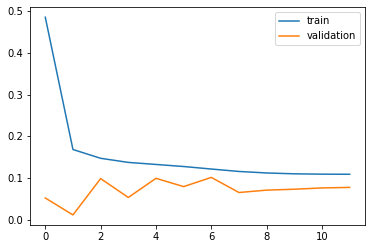


predict: [[26.84427465 33.13265644]]
real:      [[30.94384615 32.64210526]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3437 - mean_squared_error: 0.1893 - val_loss: 0.1453 - val_mean_squared_error: 0.0244
Epoch 2/1000
 - 0s - loss: 0.1565 - mean_squared_error: 0.0408 - val_loss: 0.0510 - val_mean_squared_error: 0.0027
Epoch 3/1000
 - 0s - loss: 0.1318 - mean_squared_error: 0.0273 - val_loss: 0.0740 - val_mean_squared_error: 0.0061
Epoch 4/1000
 - 0s - loss: 0.1300 - mean_squared_error: 0.0265 - val_loss: 0.0502 - val_mean_squared_error: 0.0038
Epoch 5/1000
 - 0s - loss: 0.1279 - mean_squared_error: 0.0257 - val_loss: 0.0693 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 0s - loss: 0.1251 - mean_squared_error: 0.0247 - val_loss: 0.0844 - val_mean_squared_error: 0.0106
Epoch 7/1000
 - 0s - loss: 0.1217 - mean_squared_error: 0.0235 - val_loss: 0.0927 - val_mean_squared_error: 0.0101
Epoch 8/1000
 - 0s - loss: 0.1184 - mean_squared_error: 0.0225 - val_los

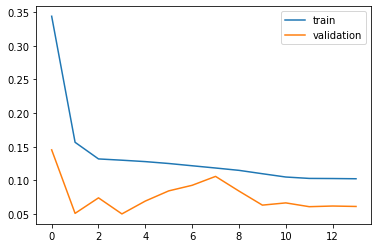


predict: [[34.96515794 33.34192531]]
real:      [[30.36       33.49736842]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4375 - mean_squared_error: 0.2740 - val_loss: 0.0701 - val_mean_squared_error: 0.0076
Epoch 2/1000
 - 0s - loss: 0.2024 - mean_squared_error: 0.0658 - val_loss: 0.2088 - val_mean_squared_error: 0.0507
Epoch 3/1000
 - 0s - loss: 0.1482 - mean_squared_error: 0.0348 - val_loss: 0.1086 - val_mean_squared_error: 0.0170
Epoch 4/1000
 - 0s - loss: 0.1364 - mean_squared_error: 0.0301 - val_loss: 0.1203 - val_mean_squared_error: 0.0198
Epoch 5/1000
 - 0s - loss: 0.1280 - mean_squared_error: 0.0268 - val_loss: 0.1045 - val_mean_squared_error: 0.0167
Epoch 6/1000
 - 0s - loss: 0.1190 - mean_squared_error: 0.0235 - val_loss: 0.0775 - val_mean_squared_error: 0.0103
Epoch 7/1000
 - 0s - loss: 0.1150 - mean_squared_error: 0.0217 - val_loss: 0.0884 - val_mean_squared_error: 0.0142
Epoch 8/1000
 - 0s - loss: 0.1107 - mean_squared_error: 0.0202 - val_los

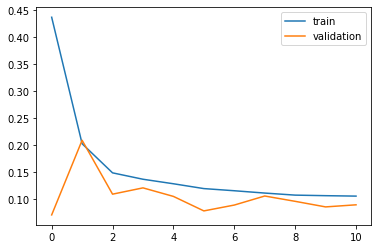


predict: [[19.67771176 33.11320822]]
real:      [[33.27923077 33.83947368]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3846 - mean_squared_error: 0.1914 - val_loss: 0.0686 - val_mean_squared_error: 0.0047
Epoch 2/1000
 - 0s - loss: 0.1600 - mean_squared_error: 0.0412 - val_loss: 0.0416 - val_mean_squared_error: 0.0019
Epoch 3/1000
 - 0s - loss: 0.1393 - mean_squared_error: 0.0298 - val_loss: 0.0732 - val_mean_squared_error: 0.0103
Epoch 4/1000
 - 0s - loss: 0.1284 - mean_squared_error: 0.0259 - val_loss: 0.0732 - val_mean_squared_error: 0.0090
Epoch 5/1000
 - 1s - loss: 0.1228 - mean_squared_error: 0.0241 - val_loss: 0.0735 - val_mean_squared_error: 0.0091
Epoch 6/1000
 - 0s - loss: 0.1173 - mean_squared_error: 0.0222 - val_loss: 0.0547 - val_mean_squared_error: 0.0056
Epoch 7/1000
 - 1s - loss: 0.1128 - mean_squared_error: 0.0209 - val_loss: 0.0823 - val_mean_squared_error: 0.0077
Epoch 8/1000
 - 1s - loss: 0.1119 - mean_squared_error: 0.0204 - val_los

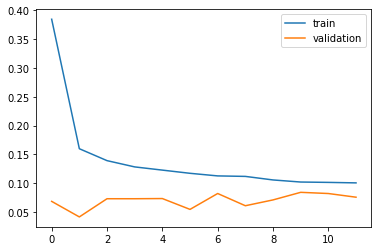


predict: [[23.94308574 32.8154441 ]]
real:      [[29.77615385 33.66842105]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3534 - mean_squared_error: 0.1755 - val_loss: 0.1989 - val_mean_squared_error: 0.0582
Epoch 2/1000
 - 0s - loss: 0.1629 - mean_squared_error: 0.0411 - val_loss: 0.2040 - val_mean_squared_error: 0.0430
Epoch 3/1000
 - 0s - loss: 0.1395 - mean_squared_error: 0.0317 - val_loss: 0.2059 - val_mean_squared_error: 0.0426
Epoch 4/1000
 - 0s - loss: 0.1328 - mean_squared_error: 0.0283 - val_loss: 0.2229 - val_mean_squared_error: 0.0498
Epoch 5/1000
 - 1s - loss: 0.1273 - mean_squared_error: 0.0264 - val_loss: 0.2365 - val_mean_squared_error: 0.0562
Epoch 6/1000
 - 1s - loss: 0.1224 - mean_squared_error: 0.0244 - val_loss: 0.2368 - val_mean_squared_error: 0.0574
Epoch 7/1000
 - 0s - loss: 0.1126 - mean_squared_error: 0.0208 - val_loss: 0.1700 - val_mean_squared_error: 0.0305
Epoch 8/1000
 - 0s - loss: 0.1081 - mean_squared_error: 0.0191 - val_los

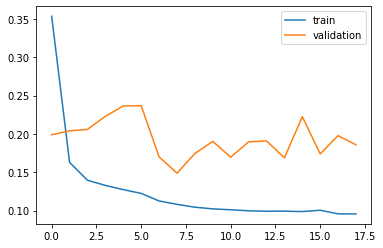


predict: [[24.86591462 32.55895834]]
real:      [[31.52769231 34.18157895]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4072 - mean_squared_error: 0.2277 - val_loss: 0.1454 - val_mean_squared_error: 0.0338
Epoch 2/1000
 - 0s - loss: 0.1529 - mean_squared_error: 0.0387 - val_loss: 0.1522 - val_mean_squared_error: 0.0371
Epoch 3/1000
 - 0s - loss: 0.1358 - mean_squared_error: 0.0295 - val_loss: 0.1786 - val_mean_squared_error: 0.0606
Epoch 4/1000
 - 0s - loss: 0.1262 - mean_squared_error: 0.0253 - val_loss: 0.1498 - val_mean_squared_error: 0.0441
Epoch 5/1000
 - 0s - loss: 0.1206 - mean_squared_error: 0.0232 - val_loss: 0.1771 - val_mean_squared_error: 0.0531
Epoch 6/1000
 - 0s - loss: 0.1164 - mean_squared_error: 0.0220 - val_loss: 0.1916 - val_mean_squared_error: 0.0547
Epoch 7/1000
 - 0s - loss: 0.1143 - mean_squared_error: 0.0212 - val_loss: 0.1603 - val_mean_squared_error: 0.0464
Epoch 8/1000
 - 0s - loss: 0.1110 - mean_squared_error: 0.0199 - val_los

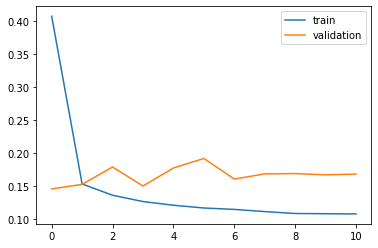


predict: [[26.17484365 32.15456297]]
real:      [[30.36       30.58947368]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3394 - mean_squared_error: 0.1598 - val_loss: 0.3070 - val_mean_squared_error: 0.1083
Epoch 2/1000
 - 0s - loss: 0.1677 - mean_squared_error: 0.0428 - val_loss: 0.1299 - val_mean_squared_error: 0.0280
Epoch 3/1000
 - 0s - loss: 0.1443 - mean_squared_error: 0.0331 - val_loss: 0.1441 - val_mean_squared_error: 0.0310
Epoch 4/1000
 - 0s - loss: 0.1345 - mean_squared_error: 0.0288 - val_loss: 0.1355 - val_mean_squared_error: 0.0351
Epoch 5/1000
 - 0s - loss: 0.1269 - mean_squared_error: 0.0260 - val_loss: 0.1482 - val_mean_squared_error: 0.0390
Epoch 6/1000
 - 0s - loss: 0.1197 - mean_squared_error: 0.0236 - val_loss: 0.1224 - val_mean_squared_error: 0.0232
Epoch 7/1000
 - 0s - loss: 0.1118 - mean_squared_error: 0.0205 - val_loss: 0.1238 - val_mean_squared_error: 0.0287
Epoch 8/1000
 - 0s - loss: 0.1087 - mean_squared_error: 0.0197 - val_los

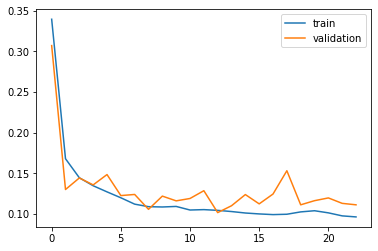


predict: [[28.4681663  32.54689686]]
real:      [[16.93153846 33.49736842]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.2252 - mean_squared_error: 0.0781 - val_loss: 0.1144 - val_mean_squared_error: 0.0154
Epoch 2/1000
 - 0s - loss: 0.1508 - mean_squared_error: 0.0351 - val_loss: 0.1051 - val_mean_squared_error: 0.0123
Epoch 3/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0282 - val_loss: 0.1378 - val_mean_squared_error: 0.0190
Epoch 4/1000
 - 0s - loss: 0.1200 - mean_squared_error: 0.0233 - val_loss: 0.1563 - val_mean_squared_error: 0.0244
Epoch 5/1000
 - 0s - loss: 0.1148 - mean_squared_error: 0.0213 - val_loss: 0.1384 - val_mean_squared_error: 0.0192
Epoch 6/1000
 - 0s - loss: 0.1111 - mean_squared_error: 0.0202 - val_loss: 0.1219 - val_mean_squared_error: 0.0149
Epoch 7/1000
 - 0s - loss: 0.1078 - mean_squared_error: 0.0192 - val_loss: 0.1076 - val_mean_squared_error: 0.0116
Epoch 8/1000
 - 0s - loss: 0.1052 - mean_squared_error: 0.0184 - val_los

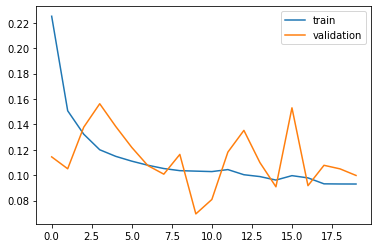


predict: [[34.0261015  32.31824254]]
real:      [[25.10538462 33.66842105]]

Maximum temperature
Test RMSE -------------------------- 10.96
Test VARIANCE ---------------------- -0.5547
Test MAX-ERROR --------------------- 34.93
Test MEAN-ABSOLUTE-ERROR ----------- 8.751
Test MEDIAN-ABSOLUTE-ERROR --------- 6.905

Minimum temperature
Test RMSE -------------------------- 1.508
Test VARIANCE ---------------------- -0.2924
Test MAX-ERROR --------------------- 3.616
Test MEAN-ABSOLUTE-ERROR ----------- 1.204
Test MEDIAN-ABSOLUTE-ERROR --------- 1.07


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict, min_max_scaler)